In [1]:
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher

feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-tiny-distilled-patch16-224')

AttributeError: type object 'DeiTForImageClassificationWithTeacher' has no attribute 'from_pretrained'

In [5]:
from transformers import DeiTFeatureExtractor, DeiTForImageClassification
from PIL import Image
import requests
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)
# note: we are loading a DeiTForImageClassificationWithTeacher from the hub here,
# so the head will be randomly initialized, hence the predictions will be random
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
model = DeiTForImageClassification.from_pretrained('facebook/deit-tiny-distilled-patch16-224')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Downloading: 100%|██████████| 23.7M/23.7M [00:04<00:00, 5.70MB/s]
Some weights of the model checkpoint at facebook/deit-tiny-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.bias', 'distillation_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.weight']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized: ['classifier.weight', 'classif

In [16]:
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt

In [12]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder('halves', transform=transform)

In [13]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

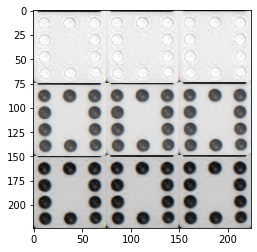

In [21]:
images, labels = next(iter(dataloader))
plt.imshow(images[0].reshape((224,224,3)))

In [22]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

In [ ]:
#Applying Transformation
train_transforms = transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])train_data = datasets.ImageFolder(data_dir + ‘/train’,  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(data_dir + ‘/test’, 
                                    transform=test_transforms)
#Data Loadingtrainloader = torch.utils.data.DataLoader(train_data,
                                                   batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)